In [1]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [2]:
from qiskit import *
%matplotlib inline

In [3]:
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [4]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
          ░ ┌─┐   
q0_0: |0>─░─┤M├───
          ░ └╥┘┌─┐
q0_1: |0>─░──╫─┤M├
          ░  ║ └╥┘
 c0_0: 0 ════╩══╬═
                ║ 
 c0_1: 0 ═══════╩═
                  

Circuit mcalcal_01
         ┌───┐ ░ ┌─┐   
q0_0: |0>┤ X ├─░─┤M├───
         └───┘ ░ └╥┘┌─┐
q0_1: |0>──────░──╫─┤M├
               ░  ║ └╥┘
 c0_0: 0 ═════════╩══╬═
                     ║ 
 c0_1: 0 ════════════╩═
                       

Circuit mcalcal_10
               ░ ┌─┐   
q0_0: |0>──────░─┤M├───
         ┌───┐ ░ └╥┘┌─┐
q0_1: |0>┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
 c0_0: 0 ═════════╩══╬═
                     ║ 
 c0_1: 0 ════════════╩═
                       

Circuit mcalcal_11
         ┌───┐ ░ ┌─┐   
q0_0: |0>┤ X ├─░─┤M├───
         ├───┤ ░ └╥┘┌─┐
q0_1: |0>┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
 c0_0: 0 ═════════╩══╬═
                     ║ 
 c0_1: 0 ════════════╩═
                       



In [6]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [7]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [8]:
from qiskit import IBMQ
IBMQ.load_account()
provider= IBMQ.get_provider('ibm-q')

In [68]:
backend =provider.get_backend('ibmq_burlington')
job = qiskit.execute(meas_calibs, backend=backend, shots=8000)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

qc = QuantumCircuit(2,2)
qc.x(1)
qc.h(0)
qc.h(1)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.h(0)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = qiskit.execute(qc, backend=backend, shots=8000).result()

noisy_counts = results.get_counts()
print(noisy_counts)

[[0.954125 0.080125 0.142125 0.031625]
 [0.012875 0.889125 0.004625 0.117125]
 [0.028    0.0025   0.84     0.051125]
 [0.005    0.02825  0.01325  0.800125]]
{'00': 1527, '10': 355, '01': 3545, '11': 2573}


In [69]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

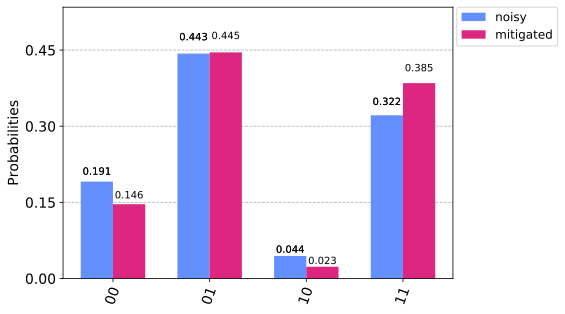

In [70]:
from qiskit.visualization import *
%config InlineBackend.figure_format = 'svg' 
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [63]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        
    return noise_model

In [21]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [22]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [71]:
noise_model = get_noise(0.20)

In [72]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=10000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.6448 0.1549 0.1534 0.0408]
 [0.16   0.646  0.0379 0.1559]
 [0.1544 0.0387 0.65   0.1585]
 [0.0408 0.1604 0.1587 0.6448]]


{'00': 1023, '10': 1034, '01': 3935, '11': 4008}


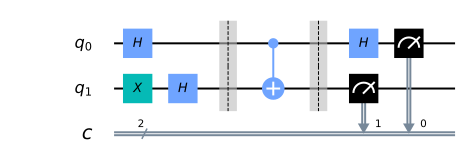

In [73]:
qc = QuantumCircuit(2,2)
qc = QuantumCircuit(2,2)
qc.x(1)
qc.h(0)
qc.h(1)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.h(0)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = qiskit.execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)
qc.draw(output="mpl")

In [74]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

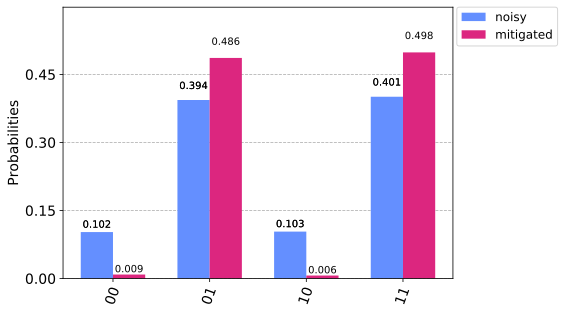

In [75]:
from qiskit.visualization import *
%config InlineBackend.figure_format = 'svg' 
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])